<a href="https://colab.research.google.com/github/Taka0007/2023seminar.2nd-term/blob/main/speech%20analysis/code/Noninterative_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 非反復の位相復元の実装
下記論文の実装　<br>
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7890450

In [7]:
# import
import heapq
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.decomposition import NMF
from scipy import signal
from tqdm import tqdm
from IPython.display import Audio

In [8]:
def calculate_phase_gradient(S, a, b, lambda_L, M):
    """
    Calculate the phase gradient for STFT.

    :param S: STFT magnitude matrix.
    :param a, b: Hop sizes.
    :param lambda_L: Scaling parameter.
    :param M: Number of frequency bins.
    :return: Phase gradient matrix.
    """
    slog = np.log(S)
    Dt = np.diff(slog, axis=0, append=slog[-1:])
    Dω = np.diff(slog, axis=1, append=slog[:, -1:])

    φSC_ω = -lambda_L / (a * M) * Dt
    φSC_t = (a * M) / lambda_L * Dω + 2 * np.pi * a / M

    return np.stack([φSC_ω, φSC_t], axis=-1)

def integrate_phase_gradient(phase_gradient, tol=0.1):
    """
    Integrate the phase gradient using heap for path management.

    :param phase_gradient: Computed phase gradient.
    :param tol: Relative magnitude tolerance.
    :return: Reconstructed phase matrix.
    """
    # ベクトルのノルムを計算
    magnitude = np.linalg.norm(phase_gradient, axis=2)
    phase = np.zeros(magnitude.shape)

    # Create a heap for managing integration paths
    heap = [(magnitude[i, j], i, j) for i in range(magnitude.shape[0]) for j in range(magnitude.shape[1])]
    heapq.heapify(heap)

    while heap:
        mag, i, j = heapq.heappop(heap)

        # Skip coefficients below tolerance
        if mag < tol:
            continue

        # Integrate phase gradient
        if i > 0:
            phase[i, j] += phase[i - 1, j] + phase_gradient[i - 1, j, 0]
        if j > 0:
            phase[i, j] += phase[i, j - 1] + phase_gradient[i, j - 1, 1]

    return np.angle(np.exp(1j * phase))

In [11]:
# Load audio file
file_path = '/content/Vinyl-sabi.wav'
audio_data, sr = librosa.load(file_path)

# Play music
Audio(audio_data, rate=sr)

<ipython-input-11-9d5e086a1298>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [12]:
# std for gaussian window (This value is determined experimentally)
std = 2048 / 6

# Compute the STFT (STFT magnitude matrix)
window = signal.windows.gaussian(2048, std)
stft_matrix = librosa.stft(audio_data, n_fft=2048, hop_length=80, win_length=2048, window=window)

a, b = 10, 10
lambda_L = 1
M = 100

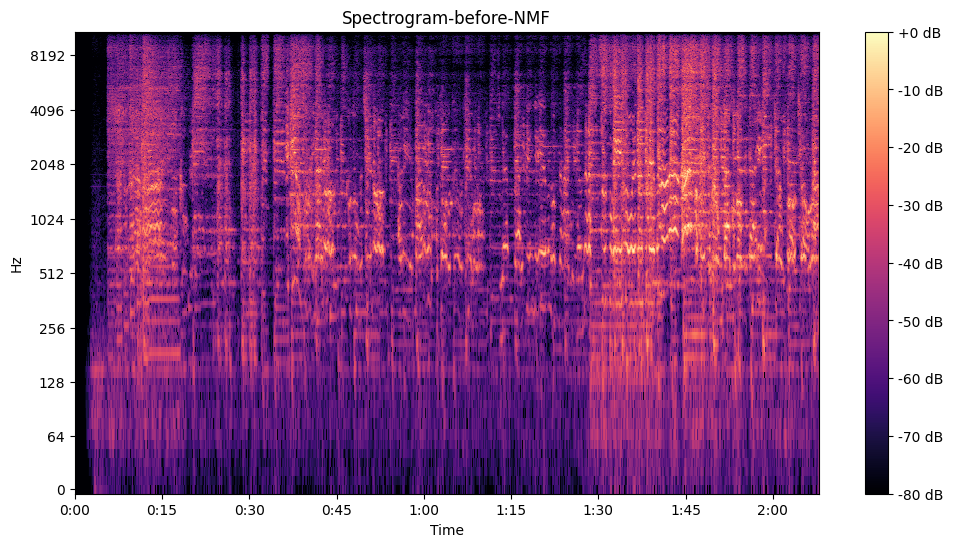

In [14]:
# 振幅を取得し、対数スケールに変換
magnitude = np.abs(stft_matrix)
log_magnitude = librosa.amplitude_to_db(magnitude, ref=np.max)

# スペクトログラムの表示
plt.figure(figsize=(12, 6))
librosa.display.specshow(log_magnitude, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram-before-phase-estimation')
plt.show()

In [15]:
phase_gradient = calculate_phase_gradient(stft_matrix, a, b, lambda_L, M)

# 位相勾配の積分を実行
reconstructed_phase = integrate_phase_gradient(phase_gradient)

# STFTの振幅成分を取得
magnitude = np.abs(stft_matrix)

# 位相情報を組み合わせる
combined_stft = magnitude * np.exp(1j * reconstructed_phase)

# 逆STFTの実行
reconstructed_signal = librosa.istft(combined_stft, hop_length=80, win_length=2048, window=window)

# 音声の再生
Audio(reconstructed_signal, rate=sr)

<ipython-input-8-72bd9db2d584>:47: ComplexWarning: Casting complex values to real discards the imaginary part
  phase[i, j] += phase[i, j - 1] + phase_gradient[i, j - 1, 1]
<ipython-input-8-72bd9db2d584>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  phase[i, j] += phase[i - 1, j] + phase_gradient[i - 1, j, 0]


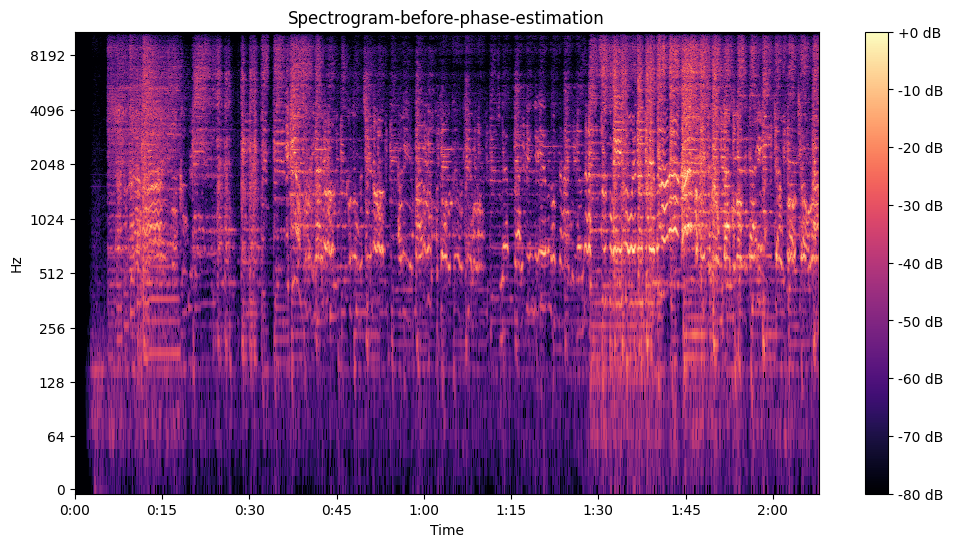

In [16]:
# std for gaussian window (This value is determined experimentally)
std = 2048 / 6

# Compute the STFT (STFT magnitude matrix)
window = signal.windows.gaussian(2048, std)
stft_matrix2 = librosa.stft(reconstructed_signal, n_fft=2048, hop_length=80, win_length=2048, window=window)

# 振幅を取得し、対数スケールに変換
magnitude2 = np.abs(stft_matrix2)
log_magnitude2 = librosa.amplitude_to_db(magnitude2, ref=np.max)

# スペクトログラムの表示
plt.figure(figsize=(12, 6))
librosa.display.specshow(log_magnitude, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram-before-phase-estimation')
plt.show()